# Processing of EUR pricing

In [3]:
#set the working directory
import os
os.chdir("/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project/")

#check
os.getcwd()

'/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project'

## Loading EUR pricing 

In [4]:
import xmltodict
import pandas as pd

xml_data = open('data/eur_pricing/euro_usd_until_july_2022.xml', 'r').read()
    #https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-usd.en.html
xmlDict = xmltodict.parse(xml_data)
    #https://stackabuse.com/reading-and-writing-xml-files-in-python-with-pandas/

In [5]:
#get dicts containing the value for Euro across time
dicts_pricing = xmlDict["CompactData"]["DataSet"]["Series"]["Obs"]
dicts_pricing[0:3]

[OrderedDict([('@TIME_PERIOD', '1999-01-04'),
              ('@OBS_VALUE', '1.1789'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')]),
 OrderedDict([('@TIME_PERIOD', '1999-01-05'),
              ('@OBS_VALUE', '1.1790'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')]),
 OrderedDict([('@TIME_PERIOD', '1999-01-06'),
              ('@OBS_VALUE', '1.1743'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')])]

We have obtained a list of dictionaries

In [14]:
print(type(dicts_pricing))
print(type(dicts_pricing[0]))

<class 'list'>
<class 'collections.OrderedDict'>


So we can extract the date and the observed value (pricing) in each dict:

In [18]:
print((dicts_pricing[0]["@TIME_PERIOD"], (dicts_pricing[0]["@OBS_VALUE"])))

('1999-01-04', '1.1789')


OBS_STATUS and OBS_CONF are exactly the same across the whole dataset

In [21]:
import numpy as np
print(np.unique([dictionary["@OBS_STATUS"] for dictionary in dicts_pricing]))
print(np.unique([dictionary["@OBS_CONF"] for dictionary in dicts_pricing]))

['A']
['F']


In [22]:
#get the value and date for each date
eur_pricing_pd = pd.DataFrame([(dictionary["@TIME_PERIOD"], dictionary["@OBS_VALUE"]) for dictionary in dicts_pricing])
eur_pricing_pd

,0,1
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6025,2022-07-13,1.0067
6026,2022-07-14,1.0005
6027,2022-07-15,1.0059
6028,2022-07-18,1.0131


In [23]:
#name the columns
eur_pricing_pd = eur_pricing_pd.set_axis(["date", "eur_usd_rate"], axis=1, inplace=False)
    #https://stackoverflow.com/questions/11346283/renaming-column-names-in-pandas
eur_pricing_pd

,date,eur_usd_rate
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6025,2022-07-13,1.0067
6026,2022-07-14,1.0005
6027,2022-07-15,1.0059
6028,2022-07-18,1.0131


In [24]:
#convert pricing to numeric
eur_pricing_pd["eur_usd_rate"] = pd.to_numeric(eur_pricing_pd["eur_usd_rate"])
    #https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
    
#convert date to datetime
eur_pricing_pd["date"] = pd.to_datetime(eur_pricing_pd["date"])

#look
eur_pricing_pd

,date,eur_usd_rate
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6025,2022-07-13,1.0067
6026,2022-07-14,1.0005
6027,2022-07-15,1.0059
6028,2022-07-18,1.0131


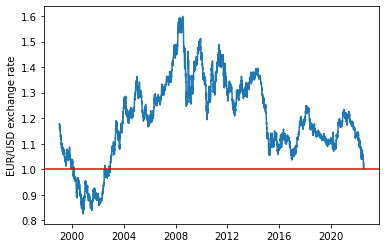

In [25]:
import matplotlib.pyplot as plt
plt.plot(eur_pricing_pd["date"], eur_pricing_pd["eur_usd_rate"])
plt.axhline(y=1, color='r', linestyle='-') #red line for EUR/USD parity
plt.ylabel('EUR/USD exchange rate')
plt.show()

Probably the most interesting thing is the peak in 2008 and then the continuous decrease. Some economists say that until 2008, the euro was a strong candidate disputing the position of global currency of the dollar, but in the debt crisis of 2008-2012, the ECB made clear that they would what ever it takes to avoid default of European countries, and this means purchasing low-quality assets like bonds of countries with a high sovereing debt. In that moment, the economy agents reduced their expectations about the Euro.

Now, we are going to create a new column with the eur pricing of the previous day. We have continous data, one day per row without gaps, so we can easily calculate the eur pricing of the exact previous day.

In [32]:
#save
eur_pricing_pd["previous_eur_pricing"] = eur_pricing_pd["eur_usd_rate"].shift(1)
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing
0,1999-01-04,1.1789,NaN
1,1999-01-05,1.1790,1.1789
2,1999-01-06,1.1743,1.1790
3,1999-01-07,1.1632,1.1743
4,1999-01-08,1.1659,1.1632
...,...,...,...
6025,2022-07-13,1.0067,1.0042
6026,2022-07-14,1.0005,1.0067
6027,2022-07-15,1.0059,1.0005
6028,2022-07-18,1.0131,1.0059


In [34]:
#check that for each row, the value in "previous_eur_pricing" is equal to "eur_usd_rate" of the previous row
check = [] #empty list to save results

#iterate across the pandas df
for index, row in eur_pricing_pd.T.iteritems():
    
    #avoid the first row that obviously has no previous eur value
    if index > 0:
        check.append(row["previous_eur_pricing"] == eur_pricing_pd["eur_usd_rate"].iloc[index-1])

#see that all True
all(check)

True

In [35]:
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing
0,1999-01-04,1.1789,NaN
1,1999-01-05,1.1790,1.1789
2,1999-01-06,1.1743,1.1790
3,1999-01-07,1.1632,1.1743
4,1999-01-08,1.1659,1.1632
...,...,...,...
6025,2022-07-13,1.0067,1.0042
6026,2022-07-14,1.0005,1.0067
6027,2022-07-15,1.0059,1.0005
6028,2022-07-18,1.0131,1.0059


We are going to calculate the percentage of change of EUR/UDS exchange rate respect to the previous day.

In [36]:
#calcualte the percentage of change in one day respect to the previous day
eur_pricing_pd["percent_change_pricing"] = ((eur_pricing_pd["eur_usd_rate"] - eur_pricing_pd["previous_eur_pricing"])/eur_pricing_pd["previous_eur_pricing"])*100
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing
0,1999-01-04,1.1789,NaN,NaN
1,1999-01-05,1.1790,1.1789,0.008482
2,1999-01-06,1.1743,1.1790,-0.398643
3,1999-01-07,1.1632,1.1743,-0.945244
4,1999-01-08,1.1659,1.1632,0.232118
...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954
6026,2022-07-14,1.0005,1.0067,-0.615874
6027,2022-07-15,1.0059,1.0005,0.539730
6028,2022-07-18,1.0131,1.0059,0.715777


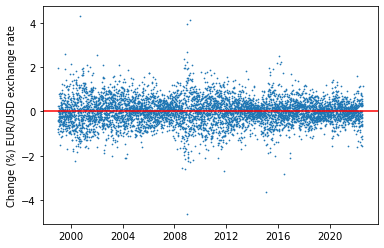

In [42]:
import matplotlib.pyplot as plt
plt.scatter(eur_pricing_pd["date"], eur_pricing_pd["percent_change_pricing"], s=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('Change (%) EUR/USD exchange rate')
plt.show()

Much more variability.

In [15]:
#eur_pricing_pd["relative_diff"] = (eur_pricing_pd["eur_usd_rate"] - eur_pricing_pd["previous_eur_pricing"]) / eur_pricing_pd["eur_usd_rate"]
#eur_pricing_pd
    #if you want to predict the pricing of the currency or its change, you cannot use this metric because 
    #already includes the value of EUR in the present day! which is the thing you want to predict. 

We are going to include as predictors the rolling mean of previoes 60, 10 and 5 days. We are interested in checking if twitter is can improve predictions over the mid-term tendencies.

In [55]:
eur_pricing_pd["5_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(5).mean()
eur_pricing_pd["10_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(10).mean()
eur_pricing_pd["60_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(60).mean()
eur_pricing_pd["120_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(120).mean()
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing,5_days_exp_rolling_mean_pricing,10_days_exp_rolling_mean_pricing,60_days_exp_rolling_mean_pricing,120_days_exp_rolling_mean_pricing
0,1999-01-04,1.1789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,1.1790,1.1789,0.008482,NaN,NaN,NaN,NaN,1.178900,1.178900,1.178900,1.178900
2,1999-01-06,1.1743,1.1790,-0.398643,NaN,NaN,NaN,NaN,1.178933,1.178918,1.178903,1.178902
3,1999-01-07,1.1632,1.1743,-0.945244,NaN,NaN,NaN,NaN,1.177389,1.178079,1.178752,1.178826
4,1999-01-08,1.1659,1.1632,0.232118,NaN,NaN,NaN,NaN,1.172659,1.175373,1.178242,1.178567
...,...,...,...,...,...,...,...,...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954,1.01320,1.02734,1.054278,1.083448,1.014261,1.023942,1.055941,1.077875
6026,2022-07-14,1.0005,1.0067,-0.615874,1.01100,1.02284,1.053007,1.082417,1.011741,1.020807,1.054326,1.076699
6027,2022-07-15,1.0059,1.0005,0.539730,1.00750,1.01902,1.051537,1.081365,1.007994,1.017115,1.052562,1.075439
6028,2022-07-18,1.0131,1.0059,0.715777,1.00542,1.01536,1.050273,1.080350,1.007296,1.015076,1.051032,1.074290


We have calculated the rolling means using the previos eur pricing. If we use the EUR value for the current day, then the moving average is calculated including the 4 previous values and the current value (assuming we are using a 5-day window). We do not want to include our label, our reponse, in the predictors.

In [58]:
eur_pricing_pd["5_days_rolling_mean_pricing"][0:6]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5    1.17226
Name: 5_days_rolling_mean_pricing, dtype: float64

In [59]:
eur_pricing_pd["eur_usd_rate"][0:6]

0    1.1789
1    1.1790
2    1.1743
3    1.1632
4    1.1659
5    1.1569
Name: eur_usd_rate, dtype: float64

In [62]:
np.mean(eur_pricing_pd["eur_usd_rate"][0:5]) == eur_pricing_pd["5_days_rolling_mean_pricing"][5]

True

Calculate now exponential moving averages avoiding again the current pricing:

In [51]:
eur_pricing_pd["5_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=5, adjust=False).mean()
eur_pricing_pd["10_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=10, adjust=False).mean()
eur_pricing_pd["60_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=60, adjust=False).mean()
eur_pricing_pd["120_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=120, adjust=False).mean()
    #https://www.statology.org/exponential-moving-average-pandas/
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing,5_days_exp_rolling_mean_pricing,10_days_exp_rolling_mean_pricing,60_days_exp_rolling_mean_pricing,120_days_exp_rolling_mean_pricing
0,1999-01-04,1.1789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,1.1790,1.1789,0.008482,NaN,NaN,NaN,NaN,1.178900,1.178900,1.178900,1.178900
2,1999-01-06,1.1743,1.1790,-0.398643,NaN,NaN,NaN,NaN,1.178933,1.178918,1.178903,1.178902
3,1999-01-07,1.1632,1.1743,-0.945244,NaN,NaN,NaN,NaN,1.177389,1.178079,1.178752,1.178826
4,1999-01-08,1.1659,1.1632,0.232118,1.173850,NaN,NaN,NaN,1.172659,1.175373,1.178242,1.178567
...,...,...,...,...,...,...,...,...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954,1.012075,1.02284,1.053007,1.082417,1.014261,1.023942,1.055941,1.077875
6026,2022-07-14,1.0005,1.0067,-0.615874,1.009250,1.01902,1.051537,1.081365,1.011741,1.020807,1.054326,1.076699
6027,2022-07-15,1.0059,1.0005,0.539730,1.005300,1.01536,1.050273,1.080350,1.007994,1.017115,1.052562,1.075439
6028,2022-07-18,1.0131,1.0059,0.715777,1.004325,1.01212,1.049248,1.079492,1.007296,1.015076,1.051032,1.074290


In [65]:
#remove first rows with NaN
eur_pricing_pd = eur_pricing_pd.dropna()
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,percent_change_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing,5_days_exp_rolling_mean_pricing,10_days_exp_rolling_mean_pricing,60_days_exp_rolling_mean_pricing,120_days_exp_rolling_mean_pricing
120,1999-06-21,1.0339,1.0388,-0.471698,1.03804,1.04017,1.060603,1.092362,1.038175,1.040002,1.062343,1.087234
121,1999-06-22,1.0313,1.0339,-0.251475,1.03608,1.04040,1.060015,1.091153,1.036750,1.038892,1.061410,1.086353
122,1999-06-23,1.0280,1.0313,-0.319984,1.03450,1.03968,1.059352,1.089922,1.034933,1.037512,1.060423,1.085443
123,1999-06-24,1.0321,1.0280,0.398833,1.03320,1.03782,1.058582,1.088703,1.032622,1.035782,1.059360,1.084493
124,1999-06-25,1.0443,1.0321,1.182056,1.03282,1.03629,1.057830,1.087611,1.032448,1.035113,1.058466,1.083627
...,...,...,...,...,...,...,...,...,...,...,...,...
6025,2022-07-13,1.0067,1.0042,0.248954,1.01320,1.02734,1.054278,1.083448,1.014261,1.023942,1.055941,1.077875
6026,2022-07-14,1.0005,1.0067,-0.615874,1.01100,1.02284,1.053007,1.082417,1.011741,1.020807,1.054326,1.076699
6027,2022-07-15,1.0059,1.0005,0.539730,1.00750,1.01902,1.051537,1.081365,1.007994,1.017115,1.052562,1.075439
6028,2022-07-18,1.0131,1.0059,0.715777,1.00542,1.01536,1.050273,1.080350,1.007296,1.015076,1.051032,1.074290


We have 5910 rows in the final dataset, because the first 120 days cannot have 120 moving average, so they are NaN are removed. This is not a problem because we have EUR data since 1999, but out Twitter data starts from 2008, so we are not losing any relevant data.

Finally, save the resulting pandas df:

In [70]:
#save the final data.frame with all metrics and eur pricing
eur_pricing_pd.to_csv("results/eur_pricing_data.csv.gz", compression="gzip", index=False)
#eur_pricing_pd = pd.read_csv("results/eur_pricing_data.csv.gz", compression="gzip")